# Intro to OpenAI Gym
In this Project, I will explore a reinforcement learning agent training platform OpenAI Gym, and Python RL library PyTorch AgentNet      
* You can see documentation and more info here: https://gym.openai.com/     
* You can see their source code and mode details how it works in their git: https://github.com/openai/gym.
* PyTorch DQN Tutorial: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html


## High-level overview

The Atari 2600 Freeway game is a good test of RL concepts. The agent has to decide which action to take - left, up, down, or right, [0,1,2,3], and which obstacles to avoid, [cars]. I will use a DQN to train the agent. For background on DQN's, please read the Google Paper here - https://applied.cs.colorado.edu/pluginfile.php/23395/mod_resource/content/1/MnihEtAlHassibis15NatureControlDeepRL.pdf
. Our Deep Q-Learning model will use a CNN to process a series of game states and find the appropriate action to take. The network takes np arrays corresponding to pixels as input and outputs a set of Q values for each action. The action with the highest Q value will be taken by the agent. In order to perfect our model, the agent must do some exploration. In DQN's the agent will cache experiences and use memory recall to update Q-values. Unfortunately I was not able to replicate Google's 10,000 episodes of training due to storage contraints, which made training for games like Skiing-V0, and Assault-V0 difficult, however, I was able to achieve some training success on lower level games. I chose to present my findings with the Freeway game because it is a good display of how much an agent can learn in less than 100 episodes of training (with batch of 32).

## What does the game look like?

Enivronment: Freeway V0

States: Represented by an array of pixels [210,160,3]

Actions: [0,1,2,3]

Reward: Maximize reward by: Cross the Freeway without being hit by a car


In [1]:
import gc
gc.collect()

71

In [2]:
import gym
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from pathlib import Path
import random, datetime, os, copy

from gym.spaces import Box
from gym.wrappers import FrameStack


In [3]:
gym.__version__

'0.17.3'

In [4]:
game_string = "Freeway-v0"
env = gym.make(game_string).unwrapped
env.reset()
next_state, reward, done, info = env.step(0)
print(f"{next_state.shape},\n {reward},\n {done},\n {info}")

(210, 160, 3),
 0.0,
 False,
 {'ale.lives': 0}


In [ ]:
print(env.action_space)

## Preprocessing

There are a few important preprocessing steps to take before inputting states from the environment into our CNN. Each state is a 260, 180, 3 array of pixels. Extracting information through convolutions in our model will take less time if we can reduce the dimensions of the array without losing any important information. 
* In the case of the Freeway game, the color of the cars/other objects is not important. If, for example, the chicken was supposed to walk through red cars, but not blue cars, it would be important to retain some color information, however, in this case we will use a GreyScaleConversion function to reduce the array to 1 channel instead of 3.

* We will also reduce the overall size of the image, as is done in the DQN paper. We can still retain the same information with less pixels, so we reduce the size to 84, 84. 
* I will implement skip frame function so the gym module automatically repeats the actions for 2-4 frames. (come back to this
* Lastly, I will implement a concept known as frame stack. From the PyTorch Docs: 
```
FrameStack is a wrapper that allows us to squash consecutive frames of the environment into a single observation point to feed to our learning model. This way, we can identify if Mario was landing or jumping based on the direction of his movement in the previous several frames
```
Essentially frame stack will take two consecutive states and extract transition information for the agent. 

In [5]:
#Preprocess
# https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
      #should this be 0,1 or 0,255?
        transforms = T.Compose(
            [T.Resize(self.shape), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation


# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = FrameStack(env, num_stack=4)

## Our Model

#### Agent

The agent has three actions in a DQN - 

* Act - Take a random action or follow current highest Q value (exploration vs exploitation. Our agent will act based off of a declining learning rate. 

* Cache/Recall - Store the results of taking action i at state s and the result r, s'. Recall results later for use in learning.

* Learn - Update current action policy based on sample recakked of experiences.


In [6]:
#https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html
class Chick:
    def __init__(self, state_dim, action_dim, save_dir):
        #INIT - this is where we can make tweaks to our model
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.save_dir = save_dir

        self.use_cuda = torch.cuda.is_available()

        # DNN to predict the most optimal action - we implement this in the Learn section
        self.net = ChickNet(self.state_dim, self.action_dim).float()
        if self.use_cuda:
            self.net = self.net.to(device="cuda")

        self.exploration_rate = 1
        self.exploration_rate_decay = 0.9999975
        self.exploration_rate_min = 0.1
        self.curr_step = 0

        self.save_every = 1e4  # no. of experiences between saving chickNet
        #recall and cache
        self.memory = deque(maxlen=400000)
        #batch of 32 broke colab
        self.batch_size = 32

        # TD estimate/target
        self.gamma = 0.9

        #Q update
        #self.optimizer = torch.optim.RMSprop(self.net.parameters(), lr=0.00025, weight_decay=0.95, eps=self.exploration_rate_min)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.00025)
        self.loss_fn = torch.nn.SmoothL1Loss()

        #learn
        #adjusted burnin for more exploration before training, updatd learn every to 4
        self.burnin = 10000 # min. experiences before training
        self.learn_every = 4  # no. of experiences between updates to Q_online
        self.sync_every = 1e4  # no. of experiences between Q_target & Q_online sync

    def act(self, state):
        """
    Given a state, choose an epsilon-greedy action and update value of step.

    Inputs:
    state(LazyFrame): A single observation of the current state, dimension is (state_dim)
    Outputs:
    action_idx (int): An integer representing which action chick will perform
    """
        # EXPLORE
        if np.random.rand() < self.exploration_rate:
            action_idx = np.random.randint(self.action_dim)

        # EXPLOIT
        else:
            state = state.__array__()
            if self.use_cuda:
                state = torch.tensor(state).cuda()
            else:
                state = torch.tensor(state)
            state = state.unsqueeze(0)
            action_values = self.net(state, model="online")
            action_idx = torch.argmax(action_values, axis=1).item()

        # decrease exploration_rate
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)

        # increment step
        self.curr_step += 1
        return action_idx

    def cache(self, state, next_state, action, reward, done):
        """Add the experience to memory
         Inputs:
        state (LazyFrame),
        next_state (LazyFrame),
        action (int),
        reward (float),
        done(bool))
        """
        state = state.__array__()
        next_state = next_state.__array__()

        if self.use_cuda:
            state = torch.tensor(state).cuda()
            next_state = torch.tensor(next_state).cuda()
            action = torch.tensor([action]).cuda()
            reward = torch.tensor([reward]).cuda()
            done = torch.tensor([done]).cuda()
        else:
            state = torch.tensor(state)
            next_state = torch.tensor(next_state)
            action = torch.tensor([action])
            reward = torch.tensor([reward])
            done = torch.tensor([done])

        self.memory.append((state, next_state, action, reward, done,))

    def recall(self):
        """Sample experiences from memory"""
        batch = random.sample(self.memory, self.batch_size)
        state, next_state, action, reward, done = map(torch.stack, zip(*batch))
        return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()

    def learn(self):
        """Update online action value (Q) function with a batch of experiences"""
        if self.curr_step % self.sync_every == 0:
            self.sync_Q_target()

        if self.curr_step % self.save_every == 0:
            self.save()

        if self.curr_step < self.burnin:
            return None, None

        if self.curr_step % self.learn_every != 0:
            return None, None

        # Sample from memory
        state, next_state, action, reward, done = self.recall()

        # Get TD Estimate
        td_est = self.td_estimate(state, action)

        # Get TD Target
        td_tgt = self.td_target(reward, next_state, done)

        # Backpropagate loss through Q_online
        loss = self.update_Q_online(td_est, td_tgt)

        return (td_est.mean().item(), loss)
    
    def td_estimate(self, state, action):
        current_Q = self.net(state, model="online")[
            np.arange(0, self.batch_size), action
        ]  # Q_online(s,a)
        return current_Q

    @torch.no_grad()
    def td_target(self, reward, next_state, done):
        next_state_Q = self.net(next_state, model="online")
        best_action = torch.argmax(next_state_Q, axis=1)
        next_Q = self.net(next_state, model="target")[
            np.arange(0, self.batch_size), best_action
        ]
        return (reward + (1 - done.float()) * self.gamma * next_Q).float()

    def update_Q_online(self, td_estimate, td_target):
        loss = self.loss_fn(td_estimate, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def sync_Q_target(self):
        self.net.target.load_state_dict(self.net.online.state_dict())

    def save(self):
        save_path = (
            self.save_dir / f"chick_net_{int(self.curr_step // self.save_every)}.chkpt"
        )
        torch.save(
            dict(model=self.net.state_dict(), exploration_rate=self.exploration_rate),
            save_path,
        )
        print(f"ChickNet saved to {save_path} at step {self.curr_step}")

#### Q Network

The Q Network is a CNN that will take in our preprocessed state, represented by two arrays of pixels in greyscale, with size 84,84,1, and values 0-255. I chose to use similar features to the Google DQN. Starting with a larger 8x8 kernel with 4,4 strides, and using smaller kernels and strides for each layer, while increasing the number of filters. The network will have a flattened layer with n=512, which will directly feed the output layer of n=3, given that we have 3 possible actions. 

In [7]:
#https://applied.cs.colorado.edu/pluginfile.php/23395/mod_resource/content/1/MnihEtAlHassibis15NatureControlDeepRL.pdf
#https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html
class ChickNet(nn.Module):
    """mini cnn structure
  input -> (conv2d + relu) x 3 -> flatten -> (dense + relu) x 2 -> output
  """

    def __init__(self, input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim

        if h != 84:
            raise ValueError(f"Expecting input height: 84, got: {h}")
        if w != 84:
            raise ValueError(f"Expecting input width: 84, got: {w}")

        self.online = nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

        self.target = copy.deepcopy(self.online)

        # Q_target parameters are frozen.
        for p in self.target.parameters():
            p.requires_grad = False

    def forward(self, input, model):
        if model == "online":
            return self.online(input)
        elif model == "target":
            return self.target(input)

## Logging

In [8]:
# https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html
import numpy as np
import time, datetime
import matplotlib.pyplot as plt


class MetricLogger:
    def __init__(self, save_dir):
        self.save_log = save_dir / "log"
        with open(self.save_log, "w") as f:
            f.write(
                f"{'Episode':>8}{'Step':>8}{'Epsilon':>10}{'MeanReward':>15}"
                f"{'MeanLength':>15}{'MeanLoss':>15}{'MeanQValue':>15}"
                f"{'TimeDelta':>15}{'Time':>20}\n"
            )
        self.ep_rewards_plot = save_dir / "reward_plot.jpg"
        self.ep_lengths_plot = save_dir / "length_plot.jpg"
        self.ep_avg_losses_plot = save_dir / "loss_plot.jpg"
        self.ep_avg_qs_plot = save_dir / "q_plot.jpg"

        # History metrics
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []

        # Moving averages, added for every call to record()
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []

        # Current episode metric
        self.init_episode()

        # Timing
        self.record_time = time.time()

    def log_step(self, reward, loss, q):
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        if loss:
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1

    def log_episode(self):
        "Mark end of episode"
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss / self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q / self.curr_ep_loss_length, 5)
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)

        self.init_episode()

    def init_episode(self):
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0

    def record(self, episode, epsilon, step):
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-100:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-100:]), 3)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-100:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-100:]), 3)
        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)

        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time, 3)

        print(
            f"Episode {episode} - "
            f"Step {step} - "
            f"Epsilon {epsilon} - "
            f"Mean Reward {mean_ep_reward} - "
            f"Mean Length {mean_ep_length} - "
            f"Mean Loss {mean_ep_loss} - "
            f"Mean Q Value {mean_ep_q} - "
            f"Time Delta {time_since_last_record} - "
            f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        )

        with open(self.save_log, "a") as f:
            f.write(
                f"{episode:8d}{step:8d}{epsilon:10.3f}"
                f"{mean_ep_reward:15.3f}{mean_ep_length:15.3f}{mean_ep_loss:15.3f}{mean_ep_q:15.3f}"
                f"{time_since_last_record:15.3f}"
                f"{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S'):>20}\n"
            )

        for metric in ["ep_rewards", "ep_lengths", "ep_avg_losses", "ep_avg_qs"]:
            plt.plot(getattr(self, f"moving_avg_{metric}"))
            plt.savefig(getattr(self, f"{metric}_plot"))
            plt.clf()

## Training 

Training was a constant struggle with memory errors and model adjustments. My initial model was crafted from a tutorial that used the game super mario and built to play the Skiing Atari game. Unfortunately this model did not translate very well to the Skiing game. The Slkiing game has three actions where mario was limited to 2 (right and right-jump). The Skiing game was difficult to crack because moving left or right multiple times in a row actually makes you accelerate. On top of that, the gym module automatically skips 2-4 frames randomly. This means it is hard for the network to understand acceleration from multiple commands in a row. Because of the differences I spent a lot of time tweaking different rates, playing with different preprocessing, and configuring Google colab. Eventually I found a setup that could train without encountering a memory error. Once I had this going, I started tweaking variables like frameskip rate, batch size, learning decay, gamma, which optimizer, learn_every rate, and sync_every rate. Unfortunately I could not perform enough training episodes to make the agent any good at skiing. I decided to switch games to see if my model was totally useless or could be salvaged. With a few tweaks, I had achieved great results in the Freeway game.

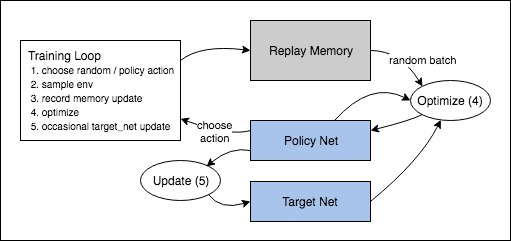

In [9]:
#https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html
use_cuda = torch.cuda.is_available()
print(f"Using CUDA: {use_cuda}")
print()


save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

chick = Chick(state_dim=(4, 84, 84), action_dim=env.action_space.n, save_dir=save_dir)

logger = MetricLogger(save_dir)

episodes = 1000
for e in range(episodes):

    state = env.reset()
    num_steps = 0
    # Play the game!
    while True:

        # Run agent on the state
        action = chick.act(state)

        # Agent performs action
        next_state, reward, done, info = env.step(action)
        num_steps += 1

        # Remember
        chick.cache(state, next_state, action, reward, done)

        # Learn
        q, loss = chick.learn()

        # Logging
        logger.log_step(reward, loss, q)

        # Update state
        state = next_state

        # Check if end of game
        if done:
            break

    logger.log_episode()

    if e % 5 == 0:
        logger.record(episode=e, epsilon=chick.exploration_rate, step=chick.curr_step)

Using CUDA: True

Episode 0 - Step 680 - Epsilon 0.9983014420601094 - Mean Reward 0.0 - Mean Length 680.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 3.509 - Time 2021-05-03T22:39:58
Episode 5 - Step 4099 - Epsilon 0.9898048140573174 - Mean Reward 0.0 - Mean Length 683.167 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 17.518 - Time 2021-05-03T22:40:16
Episode 10 - Step 7520 - Epsilon 0.9813755946776697 - Mean Reward 0.091 - Mean Length 683.636 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 17.533 - Time 2021-05-03T22:40:34
SkierNet saved to checkpoints/2021-05-03T22-39-49/skier_net_1.chkpt at step 10000
Episode 15 - Step 10928 - Epsilon 0.9730497825279539 - Mean Reward 0.125 - Mean Length 683.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 19.019 - Time 2021-05-03T22:40:53
Episode 20 - Step 14355 - Epsilon 0.9647487783424131 - Mean Reward 0.095 - Mean Length 683.571 - Mean Loss 0.0 - Mean Q Value -0.0 - Time Delta 22.325 - Time 2021-05-03T22:41:15
Episode 25 - Step 17773 - Eps

<Figure size 432x288 with 0 Axes>

## Results 

You can see the mean reward growing in the log the above cell as the episodes increase. The agent is clearly getting better and better at finding the reward as epsilon decreases (randomness degree of actions)<br>
Overall, I failed with my original goal of training an agent to be good at the Skiing game, but succeeded at the Freeway game. I think I would have been better of using the Keras RL framework given my familiarity with Keras from HW5. I ended up using the PyTorch docs examples for a DQN and a DDQN with cartpole and mario as examples. As I discussed in the training section, the model did not translate well, due to things like acceleration on multiple action attemps and the randomness of action continuity ([2,3,4] actions in a row randomly). I was able to get improvement over a random agent in most cases, with my model scoring around -14K every run and the random agent scoring 16-19K every run. However, I was unable to train for 10,000 episodes due to CUDA memory restrictions in Colab. I think with more training the model would be sound. Because of poor results, I switched Atari games to something a little bit more simple. <br>
In the following cells I compare my agent with a random agent on 100 game iterations. I then provide a video of the random agent and my agent for reference. 

In [10]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [11]:
import io
import glob
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [12]:
#Geena Kim - Cartpole Edited
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = wrappers.Monitor(env, './video', force=True)
  return env

In [22]:
#sample
env = gym.make(game_string)

env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = FrameStack(env, num_stack=4)
env = wrap_env(env)
Total = 0
runs = 100
for i in range(runs):
  total_reward = 0.0
  total_steps = 0
  obs = env.reset()

  while True:
    action = chick.act(state)
    obs, reward, done, _ = env.step(action)
    total_reward += reward
    total_steps += 1
    if done:
        break
  print("Episode %d done in %d steps, total reward %.2f" % (i, total_steps, total_reward))
  Total += total_reward
print("total: ", Total)
print("average: ", Total/runs)

Episode done in 684 steps, total reward 1.00
Episode done in 691 steps, total reward 0.00
Episode done in 682 steps, total reward 1.00
Episode done in 682 steps, total reward 0.00
Episode done in 680 steps, total reward 3.00
Episode done in 685 steps, total reward 1.00
Episode done in 682 steps, total reward 2.00
Episode done in 687 steps, total reward 3.00
Episode done in 679 steps, total reward 1.00
Episode done in 680 steps, total reward 2.00
Episode done in 670 steps, total reward 0.00
Episode done in 683 steps, total reward 1.00
Episode done in 684 steps, total reward 1.00
Episode done in 683 steps, total reward 2.00
Episode done in 680 steps, total reward 1.00
Episode done in 680 steps, total reward 2.00
Episode done in 680 steps, total reward 0.00
Episode done in 678 steps, total reward 2.00
Episode done in 683 steps, total reward 0.00
Episode done in 689 steps, total reward 0.00
Episode done in 678 steps, total reward 0.00
Episode done in 684 steps, total reward 1.00
Episode do

In [23]:
#Now Compare with random actions
for i in range(runs):
  total_reward = 0.0
  total_steps = 0
  obs = env.reset()

  while True:
    action = env.action_space.sample()
    obs, reward, done, _ = env.step(action)
    total_reward += reward
    total_steps += 1
    if done:
        break
  print("Episode done in %d steps, total reward %.2f" % (total_steps, total_reward))
  Total += total_reward
print("total: ", Total)
print("average: ", Total/runs)

Episode done in 680 steps, total reward 0.00
Episode done in 680 steps, total reward 0.00
Episode done in 680 steps, total reward 1.00
Episode done in 682 steps, total reward 0.00
Episode done in 685 steps, total reward 0.00
Episode done in 685 steps, total reward 0.00
Episode done in 680 steps, total reward 0.00
Episode done in 675 steps, total reward 0.00
Episode done in 678 steps, total reward 0.00
Episode done in 681 steps, total reward 0.00
Episode done in 689 steps, total reward 0.00
Episode done in 684 steps, total reward 0.00
Episode done in 681 steps, total reward 0.00
Episode done in 682 steps, total reward 0.00
Episode done in 685 steps, total reward 0.00
Episode done in 683 steps, total reward 0.00
Episode done in 687 steps, total reward 0.00
Episode done in 682 steps, total reward 0.00
Episode done in 676 steps, total reward 0.00
Episode done in 684 steps, total reward 0.00
Episode done in 676 steps, total reward 0.00
Episode done in 684 steps, total reward 0.00
Episode do

In [13]:
#Geena Kim - Cartpole Edited
from gym import wrappers
env = gym.make(game_string)
#env = wrappers.Monitor(env, "recording", force=True) #force=True overrides the previously generated recording
chick = Chick(state_dim=(4, 84, 84), action_dim=env.action_space.n, save_dir=save_dir)
#env = SkipFrame(env, skip=2)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = FrameStack(env, num_stack=4)
env = wrap_env(env)

total_reward = 0.0
total_steps = 0
obs = env.reset()

while True:
    action = chick.act(state)
    obs, reward, done, _ = env.step(action)
    total_reward += reward
    total_steps += 1
    if done:
        break

print("Episode done in %d steps, total reward %.2f" % (total_steps, total_reward))
env.close()
show_video()
env.env.close()

Episode done in 2745 steps, total reward 0.00


In [24]:
#Geena Kim - Cartpole Edited
#env = wrappers.Monitor(env, "recording", force=True) #force=True overrides the previously generated recording
total_reward = 0.0
total_steps = 0
obs = env.reset()

while True:
    action = env.action_space.sample()
    obs, reward, done, _ = env.step(action)
    total_reward += reward
    total_steps += 1
    if done:
        break

print("Episode done in %d steps, total reward %.2f" % (total_steps, total_reward))
env.close()
show_video()
env.env.close()

Episode done in 684 steps, total reward 0.00


### References
* https://spinningup.openai.com/en/latest/spinningup/rl_intro.html
* https://github.com/Shmuma/ptan
* https://stackoverflow.com/questions/59789059/gpu-out-of-memory-error-message-on-google-colab
* https://gym.openai.com/envs/Freeway-v0/
* https://stackoverflow.com/questions/62303994/how-to-check-the-actions-available-in-openai-gym-environment
* https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
* https://danieltakeshi.github.io/2016/11/25/frame-skipping-and-preprocessing-for-deep-q-networks-on-atari-2600-games/
* https://towardsdatascience.com/policy-gradient-methods-104c783251e0
* https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html